#Instalación e importación
Instalamos `Qiskit` y `Qiskit_machine_learning` e importamos todas las librerías que se utilizaran:
1. numpy
2. pandas
3. matplotlib
4. IPython
5. sklearn
6. torch
7. google
8. qiskit
9. qiskit_machine_learning



In [55]:
!pip -q install qiskit_machine_learning
!pip -q install qiskit

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.datasets import load_iris

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp

from torch import Tensor, cat, no_grad, manual_seed
import torch
import torch.nn as nn
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam



algorithm_globals.random_seed = 42

#Quantum Neural Networks
En esta práctica se investigará y conocerá la implementación de redes neuronales cuánticas con `Qiskit`además de su funcionamiento.

##Creación circuito
Haciendo uso de Qiskit creamos el circuito de mapeo de los datos clásicos a un espacio cuántico (espacio de Hilbert).
- Primero, definimos dos ParameterVectors llamados "input" y "weight" con el número de inputs y de pesos (parámetros entrenables).  
- Después, creamos el circuito cuántico. Este tendrá 4 qubits. Aplicamos una rotación en el eje Y a cada uno utilizando los inputs. Además, colocamos una barrera por una visualización más limpia.  
- Ahora, aplicamos puertas CNOT (cx) entre los qubits y colocamos otra barrerier.  
- Luego, volvemos a aplicar rotaciones en el eje Y a cada uno de los qubits. En este caso, utilizamos los primeros 4 pesos (weights). Posteriormente, aplicamos rotaciones en el eje X utilizando los últimos 4 weights. Además, añadimos otra barrera.  
- Por último, aplicamos otra serie de puertas CNOT en orden inverso al anterior y colocamos una barrera en el circuito.  
* Graficamos el circuito con el método `.draw()`


In [57]:
inputs = ParameterVector("input", 4)
weights = ParameterVector("weight", 8)
print(f"input parameters: {[str(item) for item in inputs.params]}")
print(f"weight parameters: {[str(item) for item in weights.params]}")

qc = QuantumCircuit(4)
qc.ry(inputs[0], 0)
qc.ry(inputs[1], 1)
qc.ry(inputs[2], 2)
qc.ry(inputs[3], 3)

qc.barrier()

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)

qc.barrier()

qc.ry(weights[0], 0)
qc.ry(weights[1], 1)
qc.ry(weights[2], 2)
qc.ry(weights[3], 3)
qc.rx(weights[4], 0)
qc.rx(weights[5], 1)
qc.rx(weights[6], 2)
qc.rx(weights[7], 3)

qc.barrier()

qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(0, 1)

qc.barrier()

qc.draw()

input parameters: ['input[0]', 'input[1]', 'input[2]', 'input[3]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]']


┌──────────────┐ ░                 ░ ┌───────────────┐┌───────────────┐ ░ »
q_0: ┤ Ry(input[0]) ├─░───■─────────────░─┤ Ry(weight[0]) ├┤ Rx(weight[4]) ├─░─»
     ├──────────────┤ ░ ┌─┴─┐           ░ ├───────────────┤├───────────────┤ ░ »
q_1: ┤ Ry(input[1]) ├─░─┤ X ├──■────────░─┤ Ry(weight[1]) ├┤ Rx(weight[5]) ├─░─»
     ├──────────────┤ ░ └───┘┌─┴─┐      ░ ├───────────────┤├───────────────┤ ░ »
q_2: ┤ Ry(input[2]) ├─░──────┤ X ├──■───░─┤ Ry(weight[2]) ├┤ Rx(weight[6]) ├─░─»
     ├──────────────┤ ░      └───┘┌─┴─┐ ░ ├───────────────┤├───────────────┤ ░ »
q_3: ┤ Ry(input[3]) ├─░───────────┤ X ├─░─┤ Ry(weight[3]) ├┤ Rx(weight[7]) ├─░─»
     └──────────────┘ ░           └───┘ ░ └───────────────┘└───────────────┘ ░ »
«                     ░ 
«q_0: ────────────■───░─
«               ┌─┴─┐ ░ 
«q_1: ───────■──┤ X ├─░─
«          ┌─┴─┐└───┘ ░ 
«q_2: ──■──┤ X ├──────░─
«     ┌─┴─┐└───┘      ░ 
«q_3: ┤ X ├───────────░─
«     └───┘           ░

In [58]:
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

Ahora podríamos definir la red neuronal cuántica tanto con SamplerQNN como con EstimatorQNN. Cada una son lo siguiente:
- *SamplerQNN*: abstracción algorítmica para extraer distribuciones de probabilidad a partir de conteos de mediciones
- *EstimatorQNN*: abstracción algorítmica para los cálculos del valor esperado

In [59]:
sampler_qnn = SamplerQNN(circuit=qc, input_params=inputs, weight_params=weights, interpret=parity, output_shape=output_shape)
sampler_qnn

Ahora, creamos un input aleatorio y unos pesos aleatorios para posteriormente realizar el backward y el forward del circuito.

In [60]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

Comprobamos que se hayan generado correctamente.

In [61]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 4 
Input: [0.77395605 0.43887844 0.85859792 0.69736803]
Number of trainable weights for SamplerQNN: 8 
Weights: [0.09417735 0.97562235 0.7611397  0.78606431 0.12811363 0.45038594
 0.37079802 0.92676499]


##Forward pass  
El forward pass consiste en que la red neuronal toma las entradas, las procesa a través de las capas ocultas y genera una salida (predicción). Luego, se calcula el error entre la salida predicha y la salida real (objetivo).
Podemos observar que la salida es la esperada, un vector con dos valores.

In [62]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

In [63]:
print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.43237624 0.56762376]].  
Shape: (1, 2)


##Backward pass  
El backward pass es el proceso de ajustar los pesos la red neuronal cuántica, comenzando desde la última capa y retrocediendo hacia la primera capa. Esto se hace mediante la aplicación de la regla de la cadena del cálculo y la propagación del error hacia atrás a través de la red. El objetivo es minimizar el error de la predicción.  
Podemos observar que obtenemos dos vectores de 8 gradientes de los pesos.


In [64]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 5.03069808e-17 -1.22298005e-16  7.02563008e-17 -2.05123896e-01
    0.00000000e+00  0.00000000e+00  1.12757026e-17  9.00654768e-02]
  [-2.08166817e-17  4.16333634e-17  6.93889390e-17  2.05123896e-01
    0.00000000e+00  0.00000000e+00 -1.38777878e-17 -9.00654768e-02]]].  
Shape: (1, 2, 8)


#Quantum NN Classifier VS. Classic NN
En esta práctica implementaremos una Quantum Neural Network de clasificación binaria. Clasificaremos dos tipos de flores (Iris-setosa, Iris-versicolor) en función de cuatro atributos (SepalLengthCm,	SepalWidthCm,	PetalLengthCm,	PetalWidthCm). Para ello usaremos las librerías de qiskit y qiskit_machine_learning. Esto será contrastado con una red neuronal clásica de clasificación.

##Preparación
  
####Importación de librerías y definición de semilla
Importamos las librerías necesarias para el desarrollo del proyecto.

###Importación y preparación Dataset
Importamos el dataset y eliminamos una de las tres especies para quedarnos con dos y realizar una clasificación binaria. Convertimos a variables categóricas numéricas la especie (Iris-setosa: 0, Iris-versicolor: 1). Dividimos los datos en train y test haciendo uso de la función train_test_split() de sklearn. En este caso los datos de train supondrán un 70% del total y test el resto.

In [65]:
df = pd.read_csv('Iris.csv')
df = df.drop('Id', axis=1)
df['Species'] = pd.Categorical(df['Species'])
df = df[df['Species'] != 'Iris-virginica']
df['Species'] = df['Species'].replace({'Iris-setosa': int(-1), 'Iris-versicolor': int(1)})

x = df.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
y = df.loc[:, ['Species']].values

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1


Confirmamos que el dataset es como se esperaba y los datos de train y test (data y labels) tienen la estructura correcta. Continuamos al siguiente paso.  
Dividimos los datos en test y train. Y los preparamos para poder ser introducidos a la red neuronal. Ademas los escalamos entre 0 y 1 para un mejor rendimiento. Ademas, vemos la estructura de los datos para confirmar que es correcta.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
y_train = y_train.flatten().astype(int)
y_test = y_test.flatten().astype(int)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Escalar los datos en el rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_c = scaler.fit_transform(X_train)
X_test_c = scaler.fit_transform(X_test)

y_train_x = [0 if x == -1 else x for x in y_train]
y_test_x =[0 if x == -1 else x for x in y_test]

Training set shape: (70, 4) (70,)
Testing set shape: (30, 4) (30,)


##QNN

###Construcción Circuito Cuántico



####Mapeo de los datos a espacio de Hilbert (Codificación Cuántica)
Para la creación del circuito definimos primero ciertos valores:
1.   Features: número de atributos (4) que serán el input del QNN
2.   Num_Qubits: número de qubits del circuito (4)
Posteriormente, se crea el circuito cuántico. Tendremos cuatro qubits (cada uno trabajara con una entrada). En estos se realiza una rotación en el eje y en función del input. Posteriormente se entrelazan todos los qubits  y se vuelve a realizar dos rotaciónes en el eje y para cada qubit. Aquí es donde entran en juego los pesos. Cada rotación se realiza en función de un peso diferente, el cual se ajustará para obtener mejores resultados. Por último, se *deshace* el entrelazamiento y se mide. Se puede observar el circuito debajo del cuadro de código.

In [67]:
features = 4
num_qubits = features

Posteriormente, definimos un ZZFeatureMap que mapeara nuestros datos numéricos a estados cuánticos. La estructura para 3 qubits es la siguiente:  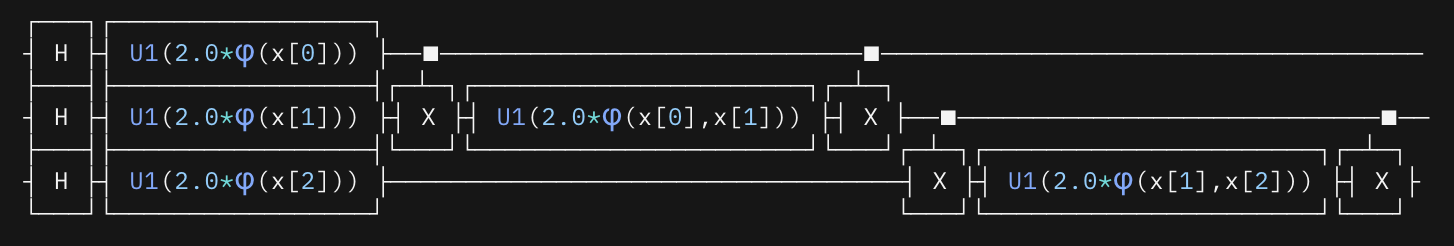

En nuestro caso, creamos un ZZFeatureMap con 4 features, una repetición y entrelazamiento completo.

In [68]:
feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")
#feature_map = PauliFeatureMap(feature_dimension = features, reps=1, paulis=['Z', 'XX'], entanglement = "full")
feature_map.decompose().draw()

┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                                    »
«q_0: ──────────────────────────────────■─────────■──»
«                                       │         │  »
«q_1: ──────────────────────────────────┼────■────┼──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──»
«     └──────────────────────────────┘└───┘└───┘┌─┴─┐»
«q_3: ──────────────────────────────────────────┤ X ├»
«                                               └───┘»
«                                                    »
«q_0: ───────────────────────────────────────■───────»
«                                            │       »
«q_1: ──────────────────────────────────■────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐  │    │  »
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼──»
«     ├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐»
«q_3: ┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├»
«     └──────────────────────────────┘     └───┘└───┘»
«                                               »
«q_0: ──────────────────────────────────────────»
«                                               »
«q_1: ──────────────────────────────────■───────»
«                                       │       »
«q_2: ──────────────────────────────────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_3: ┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├»
«     └──────────────────────────────┘└───┘└───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ─────────────────────────────────────
«                                          
«q_2: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_3: ┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
«     └──────────────────────────────┘└───┘

A continuación, creamos el ansatz. Este será un EfficientSU2 (tras investigación se llego a la conclusión de que funcionaba bien en este caso). Este tendrá 4 qubits (los de nuestro circuito), se repetirá 4 veces y tendrá entrelazamiento completo.

In [69]:
#variational_circ = RealAmplitudes(num_qubits = num_qubits, reps = 4, entanglement = "full")
circuit = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")
circuit.decompose().draw()

┌──────────┐┌──────────┐                    ┌──────────┐┌───────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■────■─────────■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├»
     ├──────────┤├──────────┤┌─┴─┐  │         │  └──────────┘└┬──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──┼────■────┼───────■───────┤ Ry(θ[9]) ├»
     ├──────────┤├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │       └──────────┘»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼────────────■──────»
     ├──────────┤├──────────┤     └───┘└───┘┌─┴─┐   ┌─┴─┐        ┌─┴─┐    »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├───────────────┤ X ├───┤ X ├────────┤ X ├────»
     └──────────┘└──────────┘               └───┘   └───┘        └───┘    »
«                                              ┌───────────┐┌───────────┐»
«q_0: ───────────────────■────────■─────────■──┤ Ry(θ[16]) ├┤ Rz(θ[20]) ├»
«     ┌───────────┐    ┌─┴─┐      │         │  └───────────┘├───────────┤»
«q_1: ┤ Rz(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────┤ Ry(θ[17]) ├»
«     ├───────────┤┌───┴───┴───┐┌─┴─┐┌─┴─┐  │        │      └───────────┘»
«q_2: ┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├┤ X ├┤ X ├──┼────────┼────────────■──────»
«     ├───────────┤├───────────┤└───┘└───┘┌─┴─┐    ┌─┴─┐        ┌─┴─┐    »
«q_3: ┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├──────────┤ X ├────┤ X ├────────┤ X ├────»
«     └───────────┘└───────────┘          └───┘    └───┘        └───┘    »
«                                              ┌───────────┐┌───────────┐»
«q_0: ───────────────────■────────■─────────■──┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«     ┌───────────┐    ┌─┴─┐      │         │  └───────────┘├───────────┤»
«q_1: ┤ Rz(θ[21]) ├────┤ X ├──────┼────■────┼────────■──────┤ Ry(θ[25]) ├»
«     ├───────────┤┌───┴───┴───┐┌─┴─┐┌─┴─┐  │        │      └───────────┘»
«q_2: ┤ Ry(θ[18]) ├┤ Rz(θ[22]) ├┤ X ├┤ X ├──┼────────┼────────────■──────»
«     ├───────────┤├───────────┤└───┘└───┘┌─┴─┐    ┌─┴─┐        ┌─┴─┐    »
«q_3: ┤ Ry(θ[19]) ├┤ Rz(θ[23]) ├──────────┤ X ├────┤ X ├────────┤ X ├────»
«     └───────────┘└───────────┘          └───┘    └───┘        └───┘    »
«                                              ┌───────────┐┌───────────┐»
«q_0: ───────────────────■────────■─────────■──┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├»
«     ┌───────────┐    ┌─┴─┐      │         │  └───────────┘├───────────┤»
«q_1: ┤ Rz(θ[29]) ├────┤ X ├──────┼────■────┼────────■──────┤ Ry(θ[33]) ├»
«     ├───────────┤┌───┴───┴───┐┌─┴─┐┌─┴─┐  │        │      └───────────┘»
«q_2: ┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├┤ X ├┤ X ├──┼────────┼────────────■──────»
«     ├───────────┤├───────────┤└───┘└───┘┌─┴─┐    ┌─┴─┐        ┌─┴─┐    »
«q_3: ┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├──────────┤ X ├────┤ X ├────────┤ X ├────»
«     └───────────┘└───────────┘          └───┘    └───┘        └───┘    »
«                               
«q_0: ──────────────────────────
«     ┌───────────┐             
«q_1: ┤ Rz(θ[37]) ├─────────────
«     ├───────────┤┌───────────┐
«q_2: ┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├
«     ├───────────┤├───────────┤
«q_3: ┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├
«     └───────────┘└───────────┘

Finalmente, combinamos nuestro Feature Map y nuestro Ansatz para tener el circuito completo.

In [70]:
combined_circuit = QuantumCircuit(features)
combined_circuit.append(feature_map, range(features))
combined_circuit.append(circuit, range(features))
combined_circuit.decompose().draw()

┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                                                                      │
«q_1: ┤1                                                                                                                                                                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31],θ[32],θ[33],θ[34],θ[35],θ[36],θ[37],θ[38],θ[39]) │
«q_2: ┤2                                                                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                                                                      │
«q_3: ┤3                                                                                                                                                                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

Posteriormente definimos el input como un ParameterVector de 4 valores. Realizamos lo mismo para los pesos pero en este caso 40 ya que son los pesos entrenables de nuestro ansatz.

In [71]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
inputsc = ParameterVector("input", 4)
weightsc = ParameterVector("weight", 40)
print(f"input parameters: {[str(item) for item in inputsc.params]}")
print(f"weight parameters: {[str(item) for item in weightsc.params]}")

input parameters: ['input[0]', 'input[1]', 'input[2]', 'input[3]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]', 'weight[8]', 'weight[9]', 'weight[10]', 'weight[11]', 'weight[12]', 'weight[13]', 'weight[14]', 'weight[15]', 'weight[16]', 'weight[17]', 'weight[18]', 'weight[19]', 'weight[20]', 'weight[21]', 'weight[22]', 'weight[23]', 'weight[24]', 'weight[25]', 'weight[26]', 'weight[27]', 'weight[28]', 'weight[29]', 'weight[30]', 'weight[31]', 'weight[32]', 'weight[33]', 'weight[34]', 'weight[35]', 'weight[36]', 'weight[37]', 'weight[38]', 'weight[39]']


###Definición observables y EstimatorQNN
Primero, definimos el observable. Este define en que eje se medirán los qubits para obtener el resultado. El observable será del tipo PauliSumOp.  
Posteriormente, definimos el EstimatorQNN, en este introducimos nuestro circuito de mapeo, el ParameterVector de inputs y pesos y el observable.

In [72]:
observable1 = PauliSumOp.from_list([("Z" * num_qubits, 1)])
print(observable1)
estimator_qnn = EstimatorQNN(circuit=combined_circuit, input_params=inputsc, weight_params=weightsc, observables=observable1)

1.0 * ZZZZ


####Comprobación
Ahora comprobamos que funciona el estimador quántico nn. Para ello cogemos la primera línea del dataset y realizamos un forward con pesos aleatorios. Se observa que se obtienen un valor o output de la QNN por lo que funciona correctamente.

In [73]:
firstrow = X_train[0]
estimator_qnn.forward(firstrow, algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.0052135]])

###Función evaluación entrenamiento
Definimos una función para observar la evolución del entrenamiento de nuestra QNN. Esta función ha sido obtenida de un [tutorial de Qiskit](https://qiskit.org/ecosystem/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html)

In [74]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

###Definición Clasificador por redes neuronales cuánticas
En este paso se define el clasificador QNN. Para ello se utiliza la función NeuralNetworkClassifier a la que se le pasa el estimato_qnn definido anteriormente, el optimizador COBYLA (estimador parecido a optimizador clásico) con un máximo de 100 iters y la función de evaluación del proceso de entrenamiento.

In [105]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=300, tol = 0.001), callback=callback_graph
)

###Entrenamiento y Score
Por último, entrenamos el clasificador con el método .fit() pasándole los datos de entrenamiento. Además, vemos el score con los datos de test.

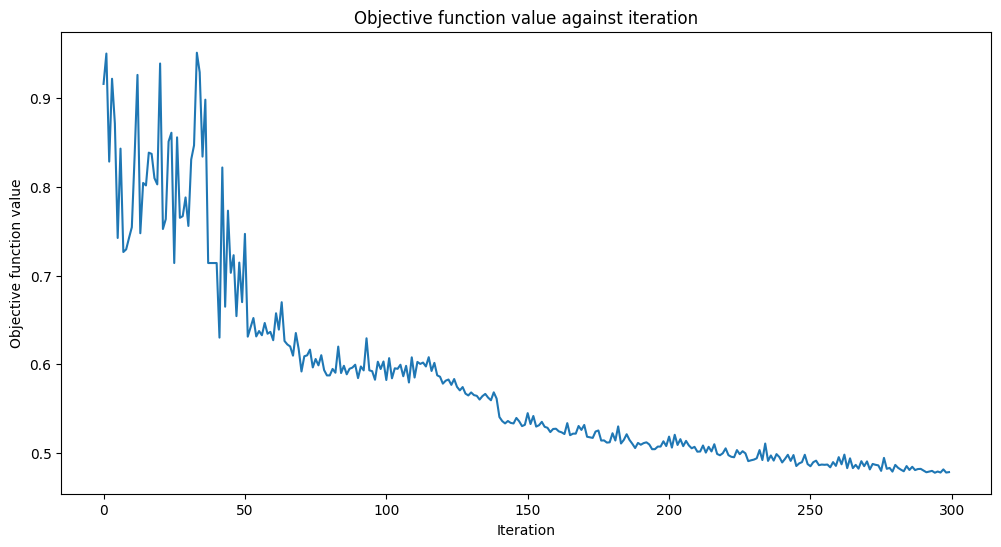

In [106]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train_c, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [107]:
print(f"Training Accuracy: {round(estimator_classifier.score(X_train_c, y_train)*100,3)}%")
print(f"Test Accuracy: {round(estimator_classifier.score(X_test_c, y_test)*100,3)}%")

Training Accuracy: 95.714%
Test Accuracy: 83.333%


Se puede observar que se obtiene alrededor de 100% de precisión  para los datos de train y alrededor de 85% para los de test.

##CNN


###Construcción NN Clásica


####Definición Arquitectura NN
Se define una arquitectura NN para clasificación utilizando la biblioteca PyTorch. La clase "NeuralNetworkClassificationModel" recibe "nn.Module" y utiliza tres capas lineales cuya función de activación es la función ReLU. La primera capa es la capa de entrada, que tiene la dimensión del espacio de entrada (4) y 128 neuronas, seguida de una capa oculta con 128 a 64 neuronas y, finalmente, la capa de salida con 64 neuronas a la dimensión de salida (2). La función "forward" define cómo se propaga la entrada a través de la red, aplicando la función de activación ReLU después de cada capa, excepto la capa de salida.

In [78]:

class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NeuralNetworkClassificationModel,self).__init__()
        self.input_layer    = nn.Linear(input_dim,128)
        self.hidden_layer1  = nn.Linear(128,64)
        self.output_layer   = nn.Linear(64,output_dim)
        self.relu = nn.ReLU()


    def forward(self,x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out

input_dim  = 4
output_dim = 2
model = NeuralNetworkClassificationModel(input_dim, output_dim)

####Definición parámetros
Establecemos los parámetros de la red neuronal:

1. La tasa de aprendizaje (`learning_rate`) se establece en 0.008. Controla el tamaño de los pasos que se realizan durante la optimización del modelo.

2. Se define el criterio de pérdida como `nn.CrossEntropyLoss()`. Esta función calcula la pérdida de entropía cruzada entre las predicciones del modelo y las etiquetas verdaderas, comúnmente utilizado en problemas de clasificación.

3. Se selecciona el optimizador `torch.optim.Adam`, variante del algoritmo de descenso de gradiente estocástico. Este ajusta automáticamente la tasa de aprendizaje para cada parámetro en función de sus gradientes. Se le pasan los parámetros del modelo y la tasa de aprendizaje.

In [79]:
learning_rate = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

###Entrenamiento


####Función de entrenamiento
Creamos una función llamada `train_network`. Esta se encarga de entrenar la NN. La función recibe el modelo, el optimizador, el criterio de pérdida, los datos de entrenamiento y prueba, las epochs y las listas para almacenar variables (las pérdidas de entrenamiento y prueba).  
En esta función:
1. Eliminamos los gradientes acumulados de la iteración anterior con `optimizer.zero_grad()`.
2. Obtenemos el resultado del forward propagation del modelo en los datos de entrenamiento con `model(X_train)` y se almacena el resultado en `output_train`.
3. Calculamos la pérdida de entrenamiento `criterion(output_train, y_train)`.
4. Realizamos backward propagation para calcular los gradientes de la pérdida con respecto a los parámetros usando `loss_train.backward()`.
5. Actualizamos los parámetros de la NN con `optimizer.step()`.
6. Evaluamos los datos test con `model(X_test)` y se calculamos la pérdida de estos.
7. Se almacenan el loss de train y test.
8. Cada 50 epochs, imprimimos información sobre la época actual y las pérdida.

In [80]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()

        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)



        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()


        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

####Definición variables y datos
Posteriormente, definimos el número de épocas (20). Además, creamos dos arrays de numpy (`train_losses` y `test_losses`) para almacenar las pérdidas de entrenamiento y prueba en cada época. Por esa lógica, los arrays tienen la misma longitud que el número de epochs. También, convertimos los datos
(X_train, X_test, y_train, y_test) a tensores float de PyTorch (`torch.FloatTensor`) y las etiquetas (y_train y y_test) a tensores long (`torch.LongTensor`).

In [81]:
num_epochs = 20
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

X_train_c = torch.FloatTensor(X_train)
X_test_c = torch.FloatTensor(X_test)
y_train_c = torch.LongTensor(y_train_x)
y_test_c = torch.LongTensor(y_test_x)

####Entrenamiento del modelo (Loss Graphic)
Ahora hacemos uso de la función `train_network` con las variables definidas anteriormente obteniendo así los arrays de pérdidas de test y train. Estos los graficamos para comparar su evolución a lo largo de las epochs. Esto nos sirve para ver si la NN está convergiendo y si existe sobreajuste.

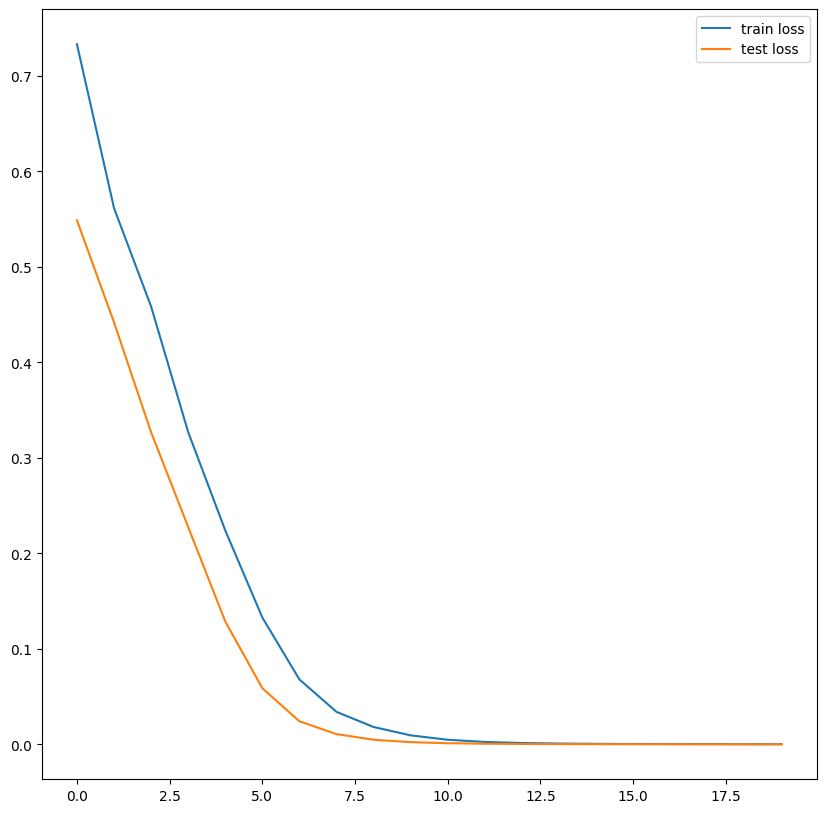

In [82]:
train_network(model,optimizer,criterion,X_train_c,y_train_c,X_test_c,y_test_c,num_epochs,train_losses,test_losses)
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

###Precisión del modelo
Ahora, definimos una función `get_accuracy_multiclass` para calcular la precisión de la CNN. La función obtiene: `pred_arr` (predicciones del modelo) y `original_arr` (labels verdaderas). Así podremos evaluar el rendimiento de nuestro modelo de clasificación.

In [83]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

Finalmente, obtenemos la precisión para los datos de test y train.

In [84]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train_c)
    predictions_test = model(X_test_c)

train_acc = get_accuracy_multiclass(predictions_train,y_train_c)
test_acc  = get_accuracy_multiclass(predictions_test,y_test_c)

print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 100.0
Test Accuracy: 100.0


Observamos que para ambos la precisión es del 100% por lo que podríamos decir que el modelo es capaz de diferenciar en el 100% de los casos entre los dos tipos de flores.

#Integración de modelos (*Torch Connector*)

Finalmente, realizamos la integración de QNNs y NNs con TorchConnector.  
Para ello primero definimos como será nuestra QNN. Esta tendrá la misma estructura que antes pero tendrá dos qubits y recibirá dos inputs

In [99]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = EfficientSU2(num_qubits = 2, reps = 4, entanglement = "full")
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn
qnn = create_qnn()

Posteriormente, definimos nuestro modelo híbrido. Este tiene la siguiente estructura:  
El método `__init__` define la arquitectura del modelo, que es la siguiente:
1. `input_layer`: Capa de entrada con una transformación lineal que mapea las entradas de 4 dimensiones a 128 dimensiones.
2. `hidden_layer1`: Capa oculta con una transformación lineal que mapea las entradas de 128 dimensiones a 64 dimensiones.
3. `output_layer`: Capa de salida con una transformación lineal que mapea las entradas de 64 dimensiones a 2 dimensiones.
4. `relu`: Función de activación ReLU.
5. `qnn`: Conector que enlaza la red neuronal clásica con la red neuronal cuántica.
6. `fc3`: Capa lineal final que mapea la salida 1-dimensional del QNN a una salida 1-dimensional.

El método `forward` define cómo se procesan las entradas a través de la red:
1. La entrada `x` se pasa a través de la capa de entrada, seguida de la función de activación ReLU.
2. A continuación, se pasa a través de la capa oculta y otra vez se aplica la función de activación ReLU.
3. Luego, se pasa a través de la capa de salida.
4. La salida de la red neuronal clásica se alimenta a la red neuronal cuántica (`self.qnn(x)`).
5. La salida del QNN se pasa a través de la capa lineal final `fc3`.
6. Finalmente, se concatena la salida `x` con `1 - x` a lo largo de la última dimensión, devolviendo un tensor de dos dimensiones.

In [100]:
class HybridModel(torch.nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.input_layer = nn.Linear(4, 128)
        self.hidden_layer1 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN


    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.output_layer(x)
        x = self.qnn(x)  # Feed the output of the classical neural network to the QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)
hybrid_model = HybridModel(qnn)

Ahora, definimos el optimizador (en este caso Adam, con un lr de 0.001) y la función de pérdida (en este caso NLLLoss, utilizada para problemas de clasificación). Posteriormente, entrenamos nuestro modelo, graficando por cada época la pérdida.

In [101]:
# Define tus datos de entrenamiento y objetivo (X_train, y_train)
optimizer = Adam(hybrid_model.parameters(), lr=0.001)
loss_func = torch.nn.NLLLoss()
loss_list = []  # Store loss history

num_epochs = 50
hybrid_model.train()
for epoch in range(num_epochs):
    total_loss = []
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    output = hybrid_model(X_train_c)  # Forward pass
    loss = loss_func(output, y_train_c.long())  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Optimize weights
    total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / num_epochs, loss_list[-1]))

Training [2%]	Loss: -0.4930
Training [4%]	Loss: -0.5260
Training [6%]	Loss: -0.5798
Training [8%]	Loss: -0.6407
Training [10%]	Loss: -0.6605
Training [12%]	Loss: -0.6572
Training [14%]	Loss: -0.6719
Training [16%]	Loss: -0.6846
Training [18%]	Loss: -0.6953
Training [20%]	Loss: -0.7082
Training [22%]	Loss: -0.7162
Training [24%]	Loss: -0.7163
Training [26%]	Loss: -0.7161
Training [28%]	Loss: -0.7205
Training [30%]	Loss: -0.7277
Training [32%]	Loss: -0.7348
Training [34%]	Loss: -0.7403
Training [36%]	Loss: -0.7444
Training [38%]	Loss: -0.7473
Training [40%]	Loss: -0.7498
Training [42%]	Loss: -0.7536
Training [44%]	Loss: -0.7597
Training [46%]	Loss: -0.7661
Training [48%]	Loss: -0.7709
Training [50%]	Loss: -0.7746
Training [52%]	Loss: -0.7784
Training [54%]	Loss: -0.7825
Training [56%]	Loss: -0.7867
Training [58%]	Loss: -0.7915
Training [60%]	Loss: -0.7966
Training [62%]	Loss: -0.8003
Training [64%]	Loss: -0.8033
Training [66%]	Loss: -0.8065
Training [68%]	Loss: -0.8097
Training [70%]	Los

Tras el entrenamiento, graficamos la evolución de la pérdida para ver si el modelo llega a convergencia y un posible sobre entrenamiento.

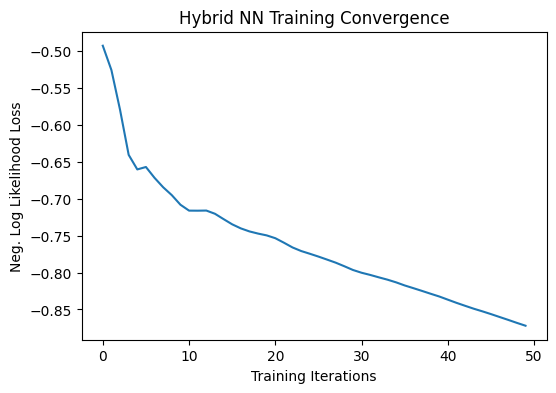

In [102]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Guardamos el modelo y lo importamos en otro para su evaluación.

In [103]:
torch.save(hybrid_model.state_dict(), "hybrid_model.pt")
modeleval = HybridModel(qnn)
modeleval.load_state_dict(torch.load("hybrid_model.pt"))

<All keys matched successfully>

Finalmente, evaluamos el rendimiento (accuracy) de nuestro modelo.

In [104]:
modeleval.eval()  # set model to evaluation mode
with no_grad():
    target = y_train_c.long()
    correct = 0
    output = modeleval(X_train_c)
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)

    print(f"Performance on train data:\n\tLoss: {loss:.4f}\n\tAccuracy: {correct / len(target) * 100:.1f}%")

with no_grad():
    target = y_test_c.long()
    correct = 0
    output = modeleval(X_test_c)
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)

    print(f"Performance on test data:\n\tLoss: {loss:.4f}\n\tAccuracy: {correct / len(target) * 100:.1f}%")

Performance on train data:
	Loss: -0.8759
	Accuracy: 100.0%
Performance on test data:
	Loss: -0.8783
	Accuracy: 100.0%


Se puede observar como con nuestro modelo híbrido también obtenemos un 100% de precisión tanto para train como para test. Sin embargo, el entrenamiento es mucho más lento por lo que en este caso no tendría sentido implementar un modelo híbrido. La solución óptima sería una red neuronal clásica.

##Bibliografía


*   Qiskit & Tutorials ([https://qiskit.org/ecosystem/machine-learning/tutorials/index.html](https://qiskit.org/ecosystem/machine-learning/tutorials/index.html))
*   Kaggle Project ([https://www.kaggle.com/code/cocoloco33/iris-dataset-with-qnn-100-score](https://www.kaggle.com/code/cocoloco33/iris-dataset-with-qnn-100-score))
*   UFV Canvas Documents
